## BayArea Data Exploration

Arezoo Besharati, UrbanSim, July 2018 


In [1]:
import os; os.chdir('../')
import numpy as np, pandas as pd 
from scipy.stats import skew
import warnings;warnings.simplefilter('ignore')
import orca
class color:
    BOLD = '\033[1m'
    END = '\033[0m'
    
# Suppress scientific notation in the Pandas display output
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Load data

In [2]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [3]:
# get a list of all existing tables
orca.list_tables()

['parcels', 'buildings', 'rentals', 'units', 'households', 'persons', 'jobs']

### Generate Node variables

In [16]:
orca.run(['initialize_network'])

Running step 'initialize_network'
Time to execute step 'initialize_network': 6.14 s
Total time to execute iteration 1 with iteration value None: 6.14 s


In [17]:
orca.run(['network_aggregations'])

Running step 'network_aggregations'
Computing accessibility variables
Computing residential_units_500
Removed 76038 rows because they contain missing values
Computing residential_units_1500
Removed 76038 rows because they contain missing values
Computing population_1500
Removed 305829 rows because they contain missing values
Computing poor_1500
Removed 79602 rows because they contain missing values
Computing renters_1500
Removed 145852 rows because they contain missing values
Computing med_income_1500
Removed 305829 rows because they contain missing values
Computing job_1500
Removed 111044 rows because they contain missing values
Computing job_25km
Removed 111044 rows because they contain missing values
Computing ave_hhsize
Removed 305829 rows because they contain missing values
Computing med_rent_sqft_1500
Computing med_rent_sqft_7000
       residential_units_500  residential_units_1500  population_1500  \
count             415716.000              415716.000       415716.000   
mean  

In [19]:
# make dataframes for all tables
frames = {name: orca.get_table(name).to_frame() for name in orca.list_tables()}

In [ ]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

## Data Quality Check

 - Checking missing values
 - Checking the data types
 - Check for feature's distributions (the skewness)


## 1. Buildings Table

In [ ]:
bld = frames['buildings']
bld.info()

### 1. 1. Missing values and data types

In [ ]:
# Does data have missing values? 

print(color.BOLD + 'Data has missing values'+ color.END if bld.isnull().values.any() else 'Data doesnt have missing values')
print ('')

# What columns/ fields/ variables
print (color.BOLD +'Columns with missing values :\n'+ color.END + '{}'.format(bld.columns[bld.isna().any()].tolist()))
print ('')

# Check features datatypes and see if there is any string feature that needs to be int/float
print(color.BOLD + 'String Features: \n'+ color.END + '{}'.format(bld.dtypes[bld.dtypes == "object"]))


costar_rent should be integer. 

In [ ]:
# change the data type and update the column
bld.costar_rent = pd.to_numeric(bld.costar_rent, errors='coerce')

# Take a count of missing values. What proportion of the data is missing? 
missing_values_count_bld = bld[['redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent']].isnull().sum()
print ('')
print(color.BOLD + 'BUILDINGS' + color.END + '\nCount of missing points: \n{}'.format (missing_values_count_bld))
print('Proportion of missing points: \n{}'.format (missing_values_count_bld/ len (bld.costar_rent)))
print ('')


- 99% of costar rent is missing!! Don't use this feature
- 40 percent of redfin sale price and year is missing 

Let's find out what proportion of the missing values is associated with rental units

In [ ]:
df = orca.merge_tables(target='units', tables = ['units','buildings'])
# Renters
prop_rentals = len(df[(df['redfin_sale_price'].isna() == True)&(df['tenure'] == 2)])/len(df)
print('{0:.2f} of data are rentals'.format(prop_rentals))

So in fact 17% of the redfin data is missing

In [ ]:
## let's look at the redfin_home_type
print (bld.redfin_home_type.unique())
print ("")
print(bld.redfin_home_type.value_counts())

In [ ]:
# See what proportion of building type is missing

missing_home_type = len(bld[(bld.redfin_home_type =='Other')|(bld.redfin_home_type =='Unknown')\
                            |(bld.redfin_home_type == '')])/len(bld)

print('{0:.2f} of data missing home type'.format(missing_home_type))

In [ ]:
# check the "res_price_per_sqft" var

bld.res_price_per_sqft.describe()

In [ ]:
import matplotlib.pylab as plt
% matplotlib notebook
plt.hist(bld.res_price_per_sqft,bins =500);
plt.show()

In [ ]:
residential_price_zero = len(bld[bld.res_price_per_sqft == 0])/len(bld)
print('The residential price per sqft for {0:.2f} of data is zero'.format(residential_price_zero))

In [ ]:
#Proportion of residential and non-residential buildings

non_residential_bld = len (bld[bld['residential_units']==0])/len(bld)
print('{0:.2f} of building are residential'.format(1- non_residential_bld))
print('{0:.2f} of building are non-residential'.format(non_residential_bld))


### 1. 2. Skewness

In [ ]:
numeric_feats = bld.dtypes[bld.dtypes != "object"].index

skewed_feats = bld[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.5]
print(color.BOLD +'Skewed features are as follows'+ color.END + '\n{}'.format (skewed_feats))

_____________________________________________________________________________________________________

## 2. Households Table

In [6]:
households = frames['households']
households.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677468 entries, 0 to 2677467
Data columns (total 21 columns):
household_id      int64
serialno          int64
persons           int64
building_type     float64
cars              float64
income            float64
race_of_head      int64
hispanic_head     object
age_of_head       int64
workers           float64
state             int64
county            int64
tract             int64
block_group       int64
children          float64
tenure            int64
recent_mover      int64
block_group_id    int64
single_family     bool
unit_id           int64
building_id       float64
dtypes: bool(1), float64(6), int64(13), object(1)
memory usage: 411.1+ MB


<IPython.core.display.Javascript object>


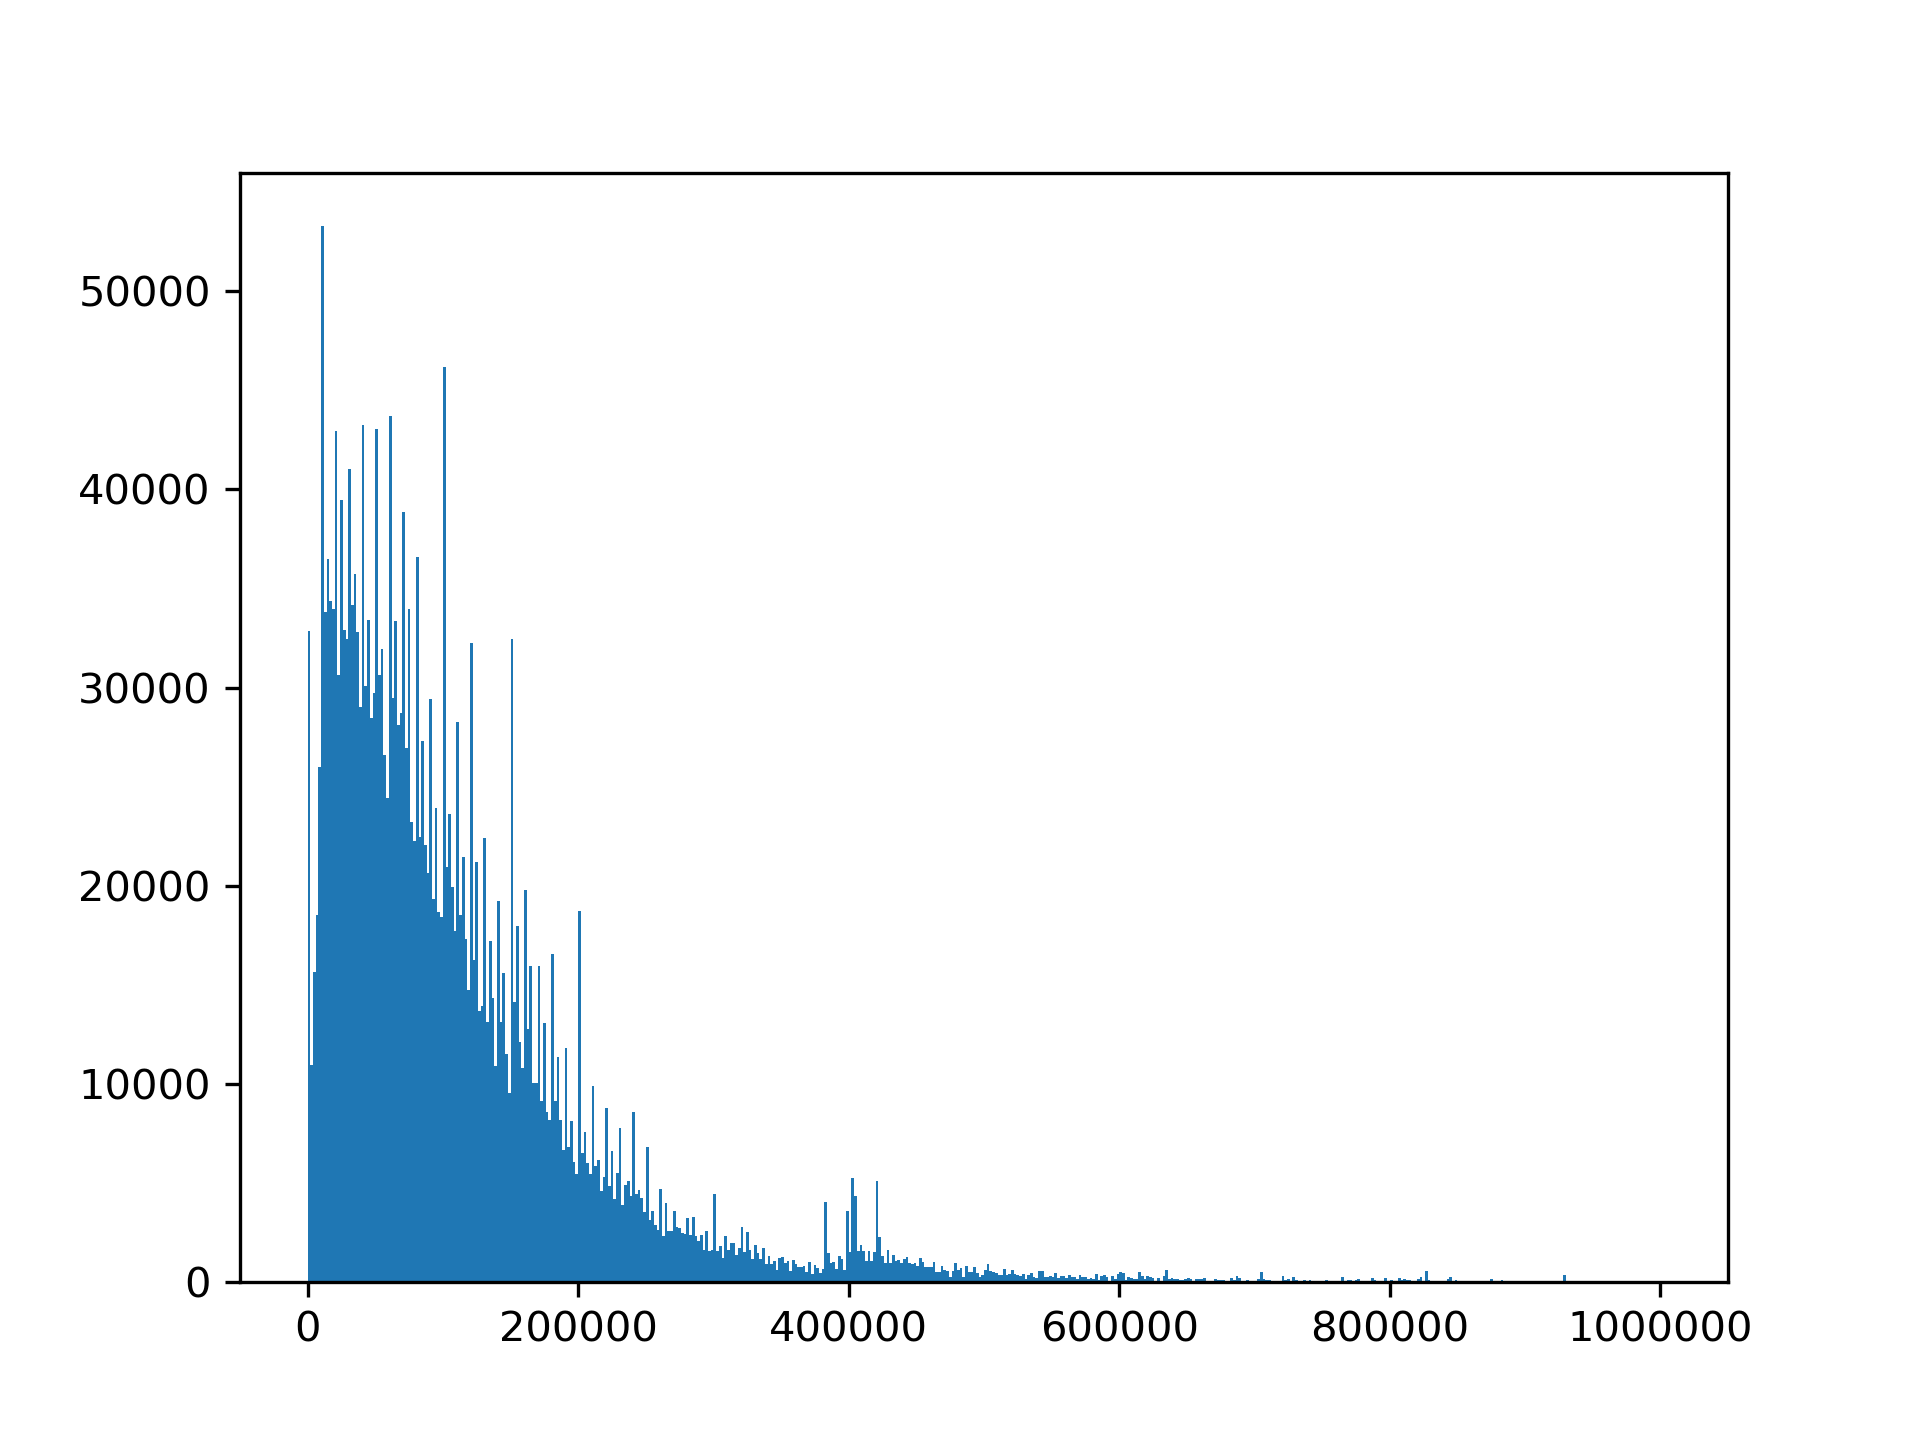

In [13]:
import matplotlib.pylab as plt
% matplotlib notebook
plt.hist(households.income,bins =500,range =(0,1000000));
plt.show()

<IPython.core.display.Javascript object>


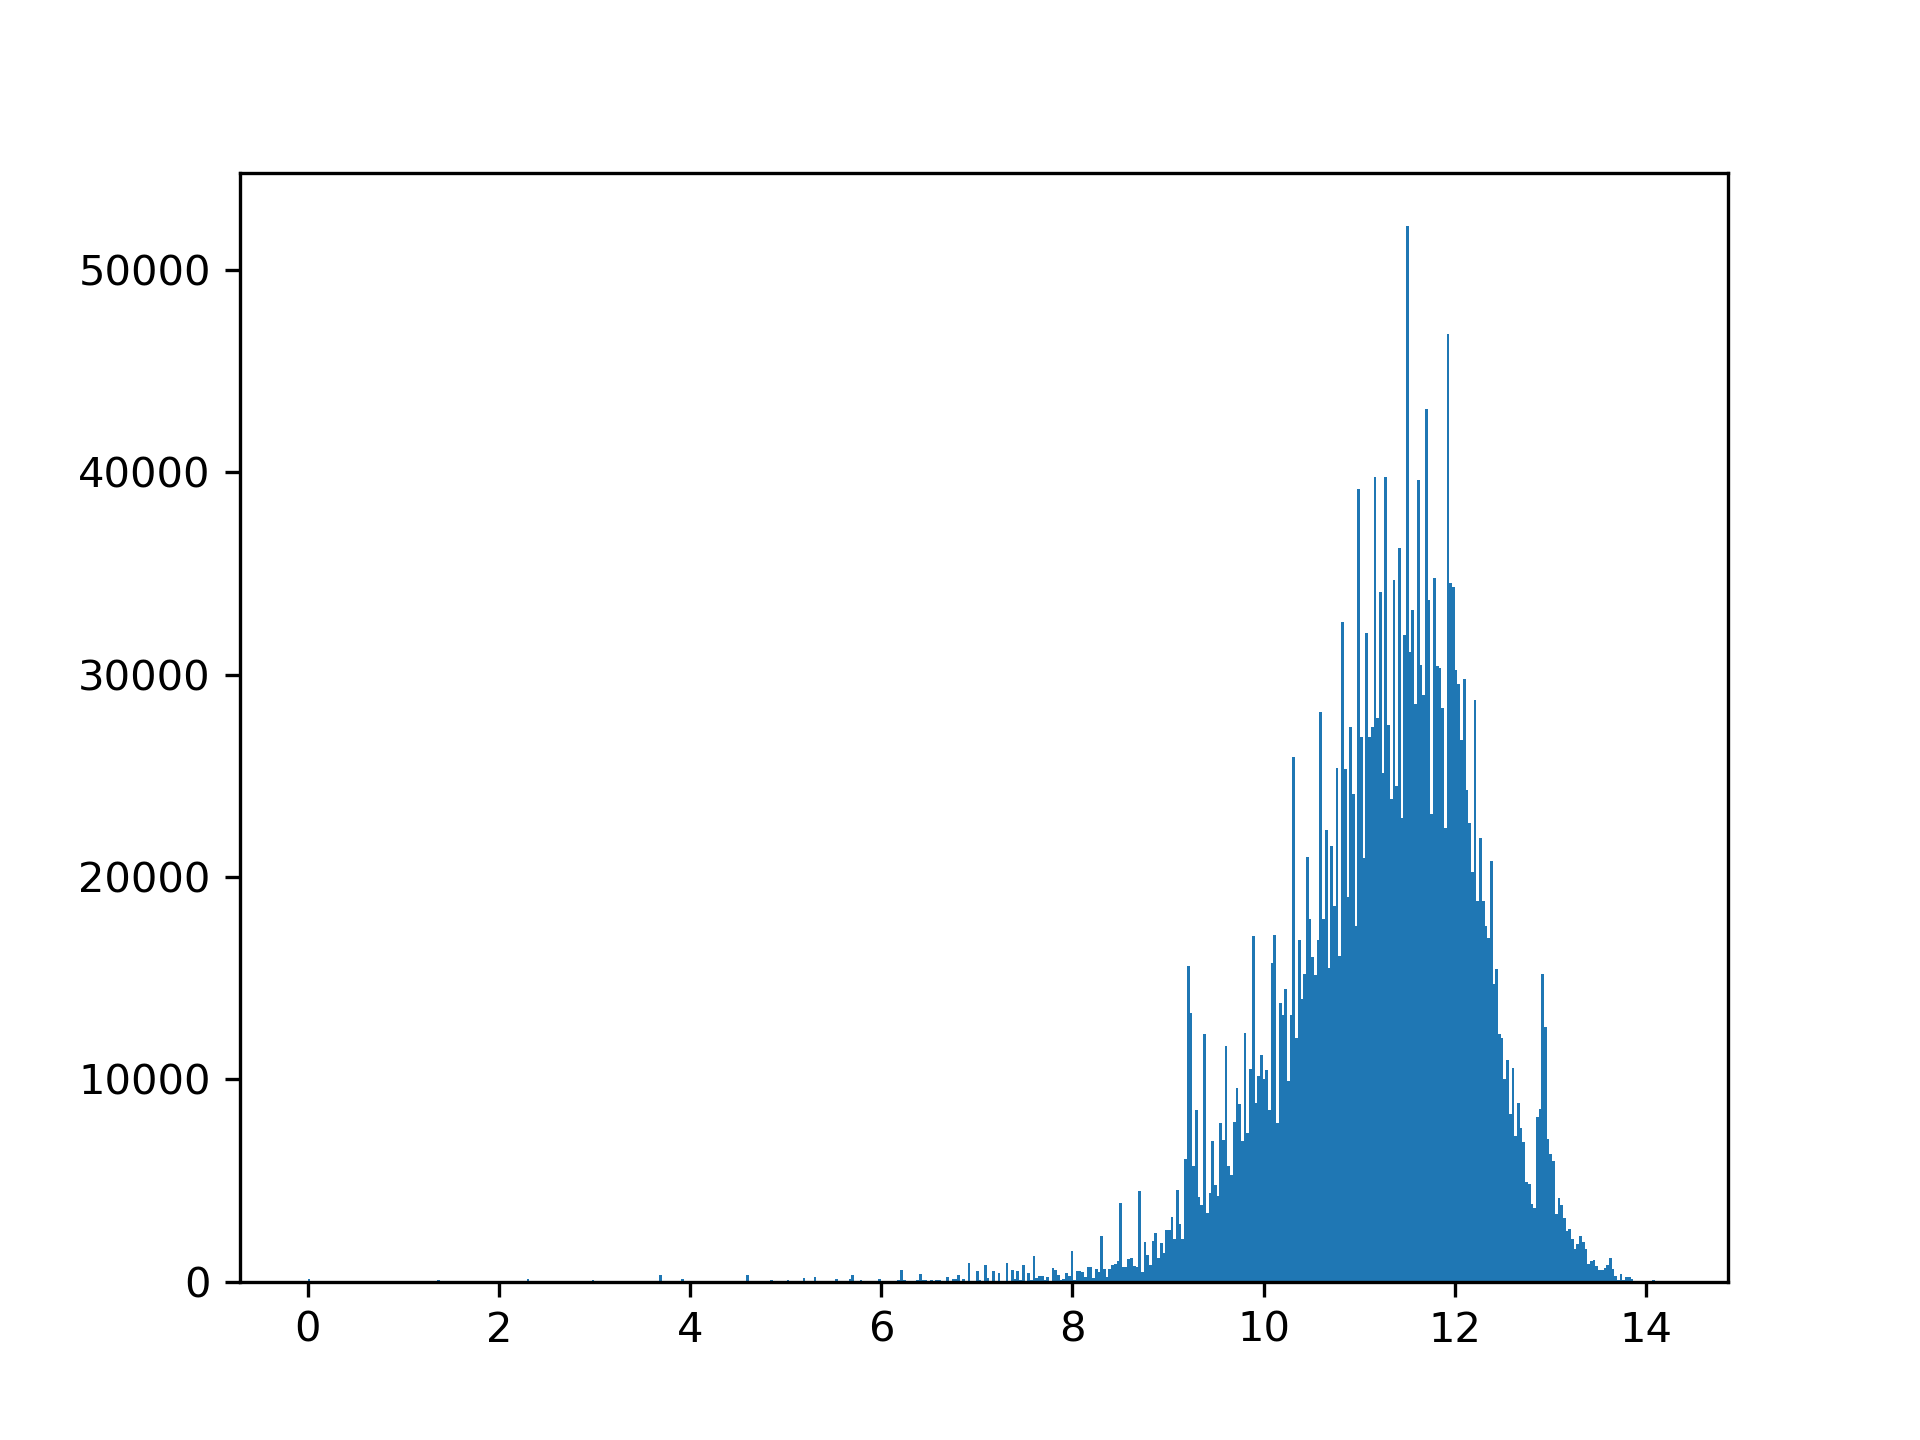

In [15]:
import matplotlib.pylab as plt
inc = households['income'][households.income>0]
lginc = np.log(inc)
% matplotlib notebook
plt.hist(lginc,bins =500);
plt.show()

### 2. 1. Missing values and data types

In [ ]:
# Does data have missing values? 
print(color.BOLD + 'Data has missing values'+ color.END if households.isnull().values.any() else 'Data doesnt have missing values')
print ('')

# What columns/ variables
print ('Columns with missing values : {}'.format(households.columns[households.isna().any()].tolist()))
print ('')

# Check features datatypes and see if there is any string feature that needs to be int/float
print(color.BOLD + 'String Features: \n'+ color.END + '{}'.format(households.dtypes[households.dtypes == "object"]))

In [ ]:
# Take a count of missing values. What proportion of the data is missing? 
missing_values_count_hh = households[['workers', 'children', 'node_id']].isnull().sum()
print ('')
print(color.BOLD + 'HOUSEHOLDS' + color.END + '\nCount of missing points: \n{}'.format (missing_values_count_hh))
print('Proportion of missing points: \n{}'.format (missing_values_count_hh/ len (households.node_id)))

_____________________________________________________________________________________________________

## 3. Parcels Table

In [ ]:
parcels = frames['parcels']
parcels.info()

In [ ]:
# Does data have missing values? 
print(color.BOLD + 'Data has missing values'+ color.END if parcels.isnull().values.any() else 'Data doesnt have missing values')
print ('')

# What columns/ variables
print ('Columns with missing values : {}'.format(parcels.columns[parcels.isna().any()].tolist()))
print ('')


#Check features datatypes and see if there is any string feature that needs to be int/float
print(color.BOLD + 'String Features: \n'+ color.END + '{}'.format(parcels.dtypes[parcels.dtypes == "object"]))
print ('')

# Take a count of missing values. What proportion of the data is missing? 
missing_values_count_parcels = parcels[['x', 'y', 'block_id', 'node_id']].isnull().sum()
print(color.BOLD + 'PARCELS' + color.END + '\nCount of missing points: \n {}'.format(missing_values_count_parcels))
print('Proportion of missing points: \n{}'.format(missing_values_count_parcels/ len(parcels.node_id)))

_____________________________________________________________________________________________________

## 4. Node Variables


In [18]:
nodes = frames['nodes']
nodes.info()

KeyError: 'nodes'

### 4. 1. Missing values and Data types

In [ ]:
# Does data have missing values? 
print(color.BOLD + 'Data has missing values'+ color.END if nodes.isnull().values.any() else 'Data doesnt have missing values')
print ('')
print ('Nodes table shape{}'.format(nodes.shape))


### 4. 2. Skewness

In [ ]:
numeric_feats = nodes.dtypes[nodes.dtypes != "object"].index

skewed_feats = nodes[numeric_feats].apply(lambda x: skew(x))
print(color.BOLD +'Skewed features are as follows'+ color.END + '\n{}'.format (skewed_feats))

## Anomaly Detection

In [ ]:
df = orca.merge_tables(target='units', tables=['units','buildings','nodes'])

In [ ]:
non_residential_sqft = len(df[df.non_residential_sqft != 0])/len(df)

print('{0:.3f} of data has non_residential space'.format(non_residential_sqft))

In [ ]:
res_price_per_sqft = len (df[df.res_price_per_sqft == 0])/ len(df)

print('{0:.3f} of data is probably not residential'.format(res_price_per_sqft))